In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data

from warnings import simplefilter

from os import path
from confer_wp3.dataloading import load_raw_data, save_anomalies, save_eofs_pcs, save_model_results
from confer_wp3.lasso_forecast import calculate_anomalies, compute_eofs_pcs, quantile_mapping, get_all_indices, get_ml_results, calculate_tercile_probability_forecasts
from confer_wp3.plotting import plot_fields_simple
from confer_wp3.validation import validate_anomalies1, validate_anomalies2, validate_anomalies3, validate_anomalies4, validate_eofs, validate_pcs, validate_indices, validate_ml_coefficients, validate_forecast

simplefilter("ignore", category=RuntimeWarning)

The following two variables specify the paths where the forecast and observation data are stored:

In [2]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'
indices_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/'
anomaly_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/seasonal/halfdeg_res/'
eof_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/'
fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls_pred/chirps/seasonal/halfdeg_res/'

Now, we set a number of parameters defining our forecast domain, training period, forecast year, etc.:

In [3]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]



### Needed?
n_eofs = 7 # Number of EOFs to compute

### CHIRPS Data

If not already available, load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, and factor loadings, and save out. Otherwise, load anomalies, EOFs and factor loadings.

##### Loading data

In [4]:
# Temporary directory for storing results
val_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/"

# Load data
year, lat, lon, prec_data = load_raw_data(chirps_dir, "chirps", [*range(year_train_start, year_train_end+1)], season, lat_bnds, lon_bnds) # 1993, 2021
prec_data.shape
print("Loaded data shape:", prec_data.shape)
print("NaN values in loaded data:", np.isnan(prec_data).sum())

Loaded data shape: (40, 67, 59)
NaN values in loaded data: 76200


##### Get/calculate anomalies and normalized anomalies

In [5]:
# Get anomalies
if not path.exists(f'{val_dir}chirps_anomalies.nc'):
    # Calculate anomalies
    anomalies = calculate_anomalies(prec_data, year, period_clm)
    # Save anomalies
    save_anomalies(anomalies, year, lat, lon, val_dir, normalized=False)
else:
    anomalies = xr.open_dataarray(f'{val_dir}chirps_anomalies.nc', engine='netcdf4')
    anomalies = anomalies.values
print(prec_data.shape)
print(anomalies.shape)
# Verify NaNs are handled correctly
print("NaN values in prec_data:", np.isnan(prec_data).sum())
print("NaN values in anomalies:", np.isnan(anomalies).sum())

(40, 67, 59)
(40, 67, 59)
NaN values in prec_data: 76200
NaN values in anomalies: 76200


In [6]:
# Get normalized anomalies
if not path.exists(f'{val_dir}chirps_anomalies_normal.nc'):
    # Apply the transformation to the anomalies data
    anomalies_normal = quantile_mapping(anomalies, year, period_clm)
    # Save normalized anomalies
    save_anomalies(anomalies_normal, year, lat, lon, val_dir, normalized=True)
else:
    anomalies_normal = xr.open_dataarray(f'{val_dir}chirps_anomalies_normal.nc', engine='netcdf4')
    anomalies_normal = anomalies_normal.values
print(anomalies_normal.shape)

(40, 67, 59)


##### Plots to ensure calculating anomalies went well

Visualize the original precipitation data and calculated anomalies on a map for a single year.


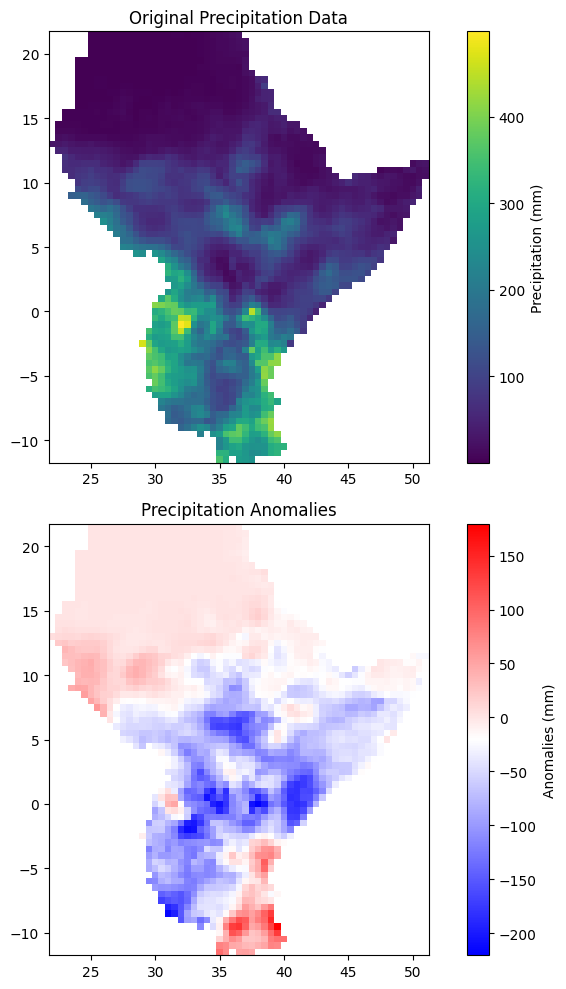

In [7]:
validate_anomalies1(prec_data, anomalies, lat, lon)

Visualize and compare original and transformed precipitation anomalies for a single year.


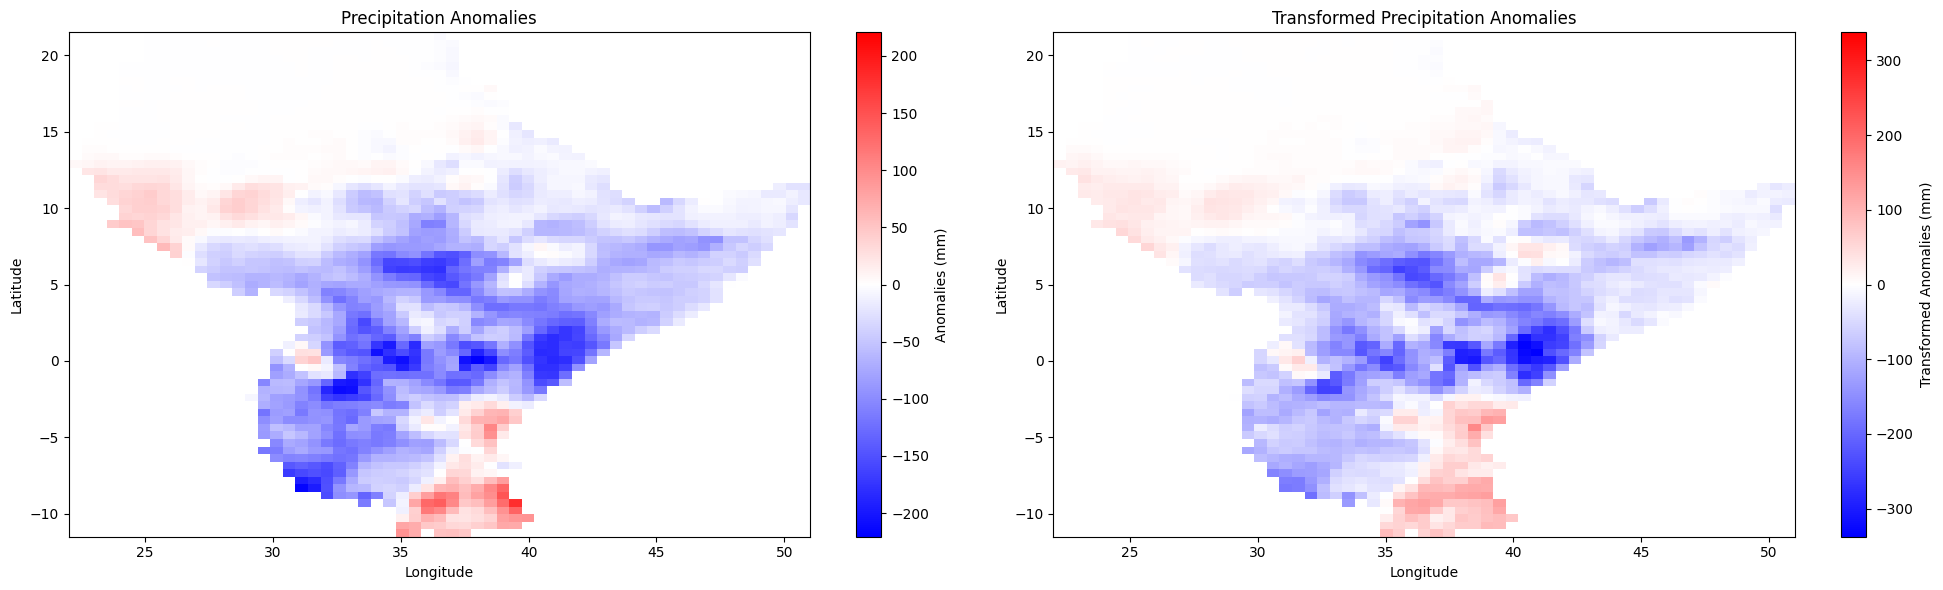

In [8]:
validate_anomalies2(anomalies, anomalies_normal, lat, lon)

Visualize and compare the distribution of original and transformed precipitation anomalies using histograms.


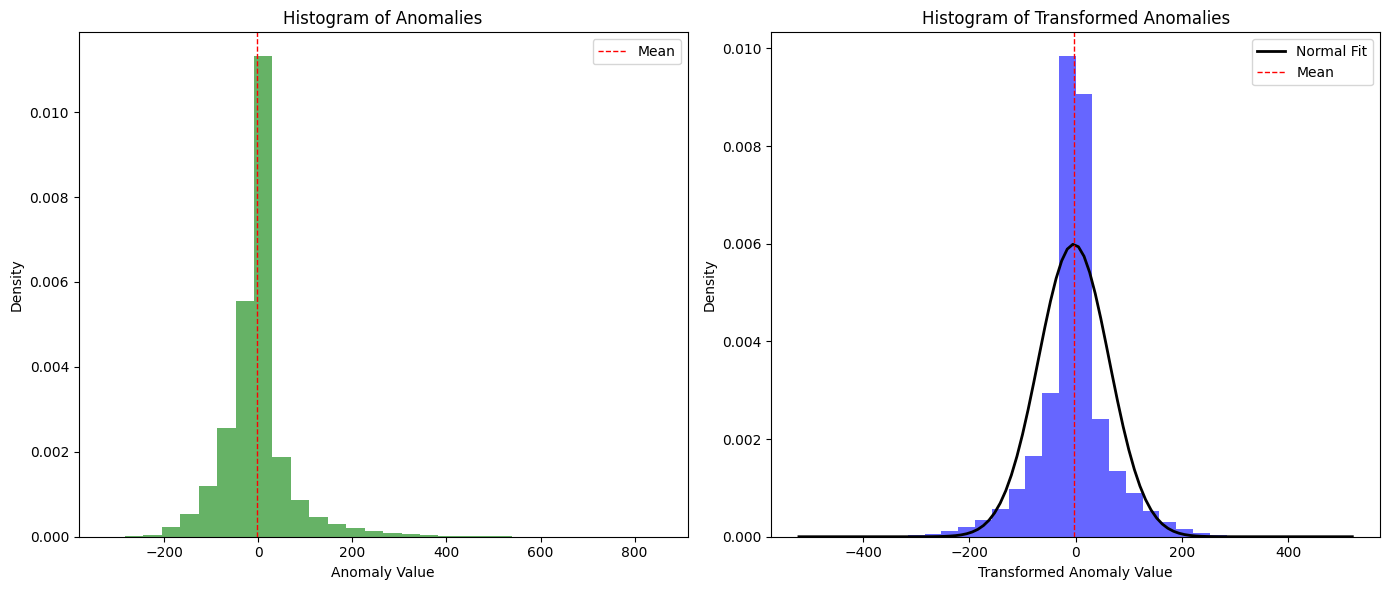

In [9]:
validate_anomalies3(anomalies, anomalies_normal)

In [10]:
validate_anomalies4(anomalies, anomalies_normal)

Printing some information about anomalies.
Anomalies - mean: -3.7547226 std: 70.41291
Transformed Anomalies - mean: -3.552454 std: 66.585884
Inf values in anomalies: 0
Inf values in transformed anomalies: 0
NaN values in anomalies: 76200
NaN values in transformed anomalies: 76200


##### Get/calculate EOFs and factor loadings

In [11]:
# Get EOFs
if not path.exists(f'{val_dir}chirps_eofs.nc'):
    # Calculate EOFs
    eofs, pcs, var_fracs = compute_eofs_pcs(anomalies_normal, n_eofs)
    # Reshape EOFs to 3D (n_eofs, lat, lon)
    eofs_reshaped = eofs.reshape((n_eofs, len(lat), len(lon)))
    # Save EOFs, PCs and variance fractions
    save_eofs_pcs(eofs_reshaped, pcs, var_fracs, year, lat, lon, val_dir)
else:
    eofs_reshaped = xr.open_dataarray(f'{val_dir}chirps_eofs.nc', engine='netcdf4').values
    pcs = xr.open_dataarray(f'{val_dir}chirps_pcs.nc', engine='netcdf4').values
    var_fracs = xr.open_dataarray(f'{val_dir}chirps_var_fracs.nc', engine='netcdf4').values
    
print("Normalized Anomalies EOFs Shape:", eofs_reshaped.shape)
print("Normalized Anomalies PCs Shape:", pcs.shape)
print("Normalized Anomalies Variance Fraction:", var_fracs, "\nSum: ", var_fracs.sum())

Normalized Anomalies EOFs Shape: (7, 67, 59)
Normalized Anomalies PCs Shape: (40, 7)
Normalized Anomalies Variance Fraction: [0.5828984  0.08871021 0.0647376  0.04039027 0.02758253 0.02055683
 0.01733351] 
Sum:  0.8422093


##### Plots to ensure calculating EOFs and factor loadings went well

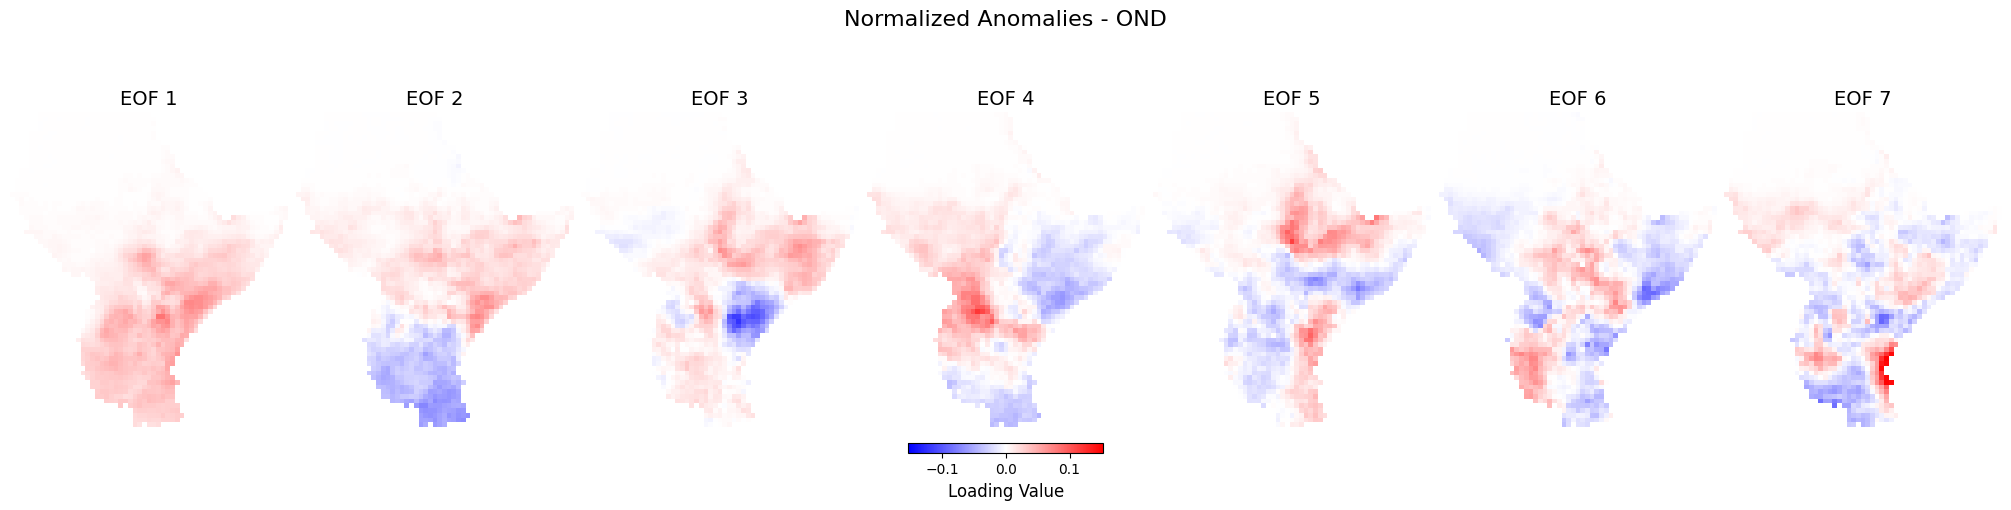

In [12]:
# Plot EOFs for normalized anomalies
validate_eofs(eofs_reshaped, f"Normalized Anomalies - {season}", n_eofs=7)

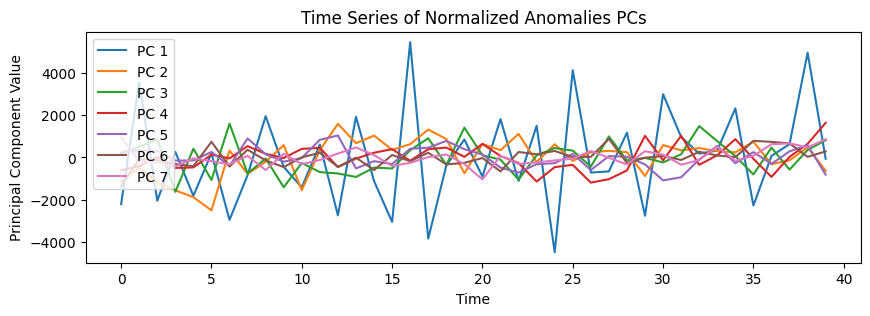

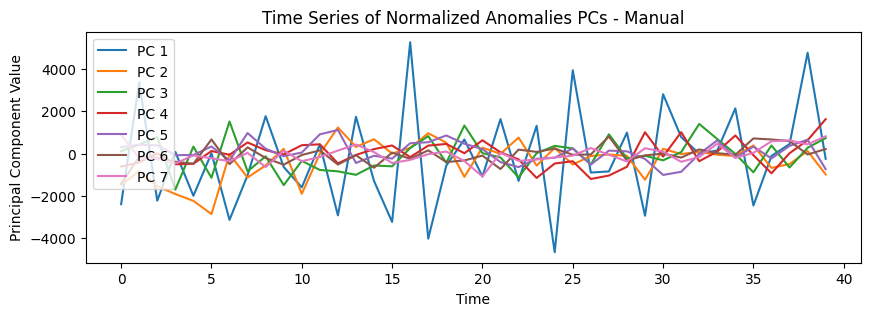

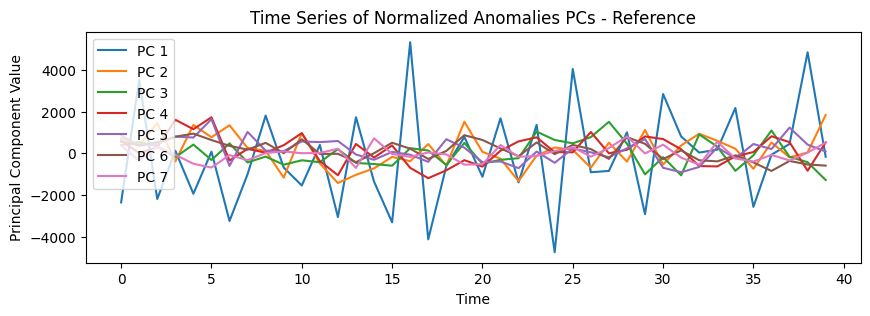

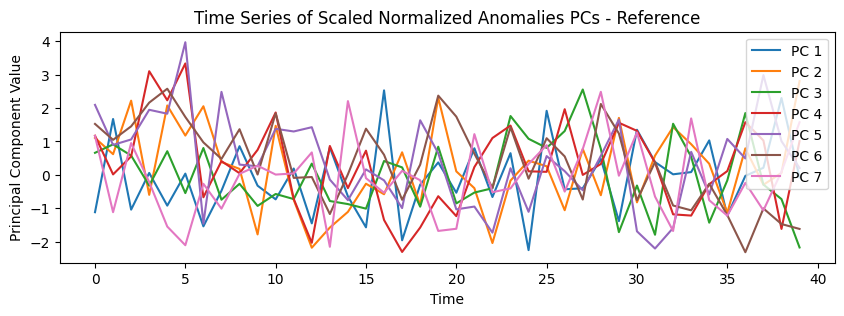

In [13]:
validate_pcs(anomalies_normal, eofs_reshaped, pcs, lat, lon, year, period_train, season, n_eofs = 7)

### ERA5 Data

If not already available, load ERA5 data, calculate indices, and save out. Otherwise, load indices.

##### Loading data

In [14]:
load_years = [*range(min(year_train_start, year_clm_start), max(year_train_end+1, year_clm_end+1))]

In [15]:
# Load sst data
sst_data = load_raw_data(era5_dir, "sst", load_years, season)
sst_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lon: 360, lat: 169)
Coordinates:
  * year     (year) int32 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -78.0 -77.0 -76.0 -75.0 -74.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (lat, lon, month, year) float32 ...

In [16]:
# Load uwind200 data
uwind200_data = load_raw_data(era5_dir, "uwind200", load_years, season)
uwind200_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

In [17]:
# Load uwind850 data
uwind850_data = load_raw_data(era5_dir, "uwind850", load_years, season)
uwind850_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

##### Get/calculate indices

In [18]:
# Get era5 indices
# Define the file path
era5_indices_path = f'{val_dir}era5_indices.nc'
# Shared between all indices
months = list(range(1, 13))

if not path.exists(era5_indices_path):
    era5_indices = get_all_indices(sst_data, uwind200_data, uwind850_data, period_clm, period_train, months)
    # Save indices
    # Convert DataFrame to xarray Dataset for saving
    ds = era5_indices.set_index(['year', 'month']).to_xarray()

    # Save the Dataset to a NetCDF file
    print("Saving indices...")
    ds.to_netcdf(era5_indices_path)
    print(f"Data saved to {era5_indices_path}")

    # Print the first few rows of the DataFrame to verify
    print(era5_indices.head)
else:
    # Load the NetCDF file into an xarray Dataset
    ds_loaded = xr.open_dataset(era5_indices_path, engine='netcdf4')
    print(f"Data loaded from {era5_indices_path}")

    # Convert the xarray Dataset back to a DataFrame
    era5_indices = ds_loaded.to_dataframe().reset_index()

    # Print the first few rows of the DataFrame to verify
    print(era5_indices.head)

Data loaded from /nr/samba/user/ahellevik/CONFER-WP3/validation_data/era5_indices.nc
<bound method NDFrame.head of      year  month       n34        n3        n4       dmi  n34_diff1  \
0    1981      1 -0.878076 -1.105121 -0.610689  0.347750  -0.310888   
1    1981      2 -1.194670 -1.445646 -0.814860 -0.049903  -0.310888   
2    1981      3 -1.183618 -1.445331 -0.922555 -0.561697   0.010853   
3    1981      4 -1.678912 -1.919827 -0.753611  0.522551  -0.486369   
4    1981      5 -1.349333 -1.029916 -0.773688 -1.361840   0.323640   
..    ...    ...       ...       ...       ...       ...        ...   
475  2020      8 -0.769404 -0.739564 -0.778996 -0.922866  -0.345186   
476  2020      9 -1.014953 -1.199928 -0.985926 -0.770179  -0.241124   
477  2020     10 -1.263689 -1.201887 -1.209699  0.172647  -0.244254   
478  2020     11 -1.150069 -1.008953 -1.061598 -0.620625   0.111573   
479  2020     12 -0.849050 -0.660425 -1.115174 -0.103469   0.295595   

     dmi_diff1       wsp       w

##### Plots to ensure calculating indices went well

Validating index: dmi


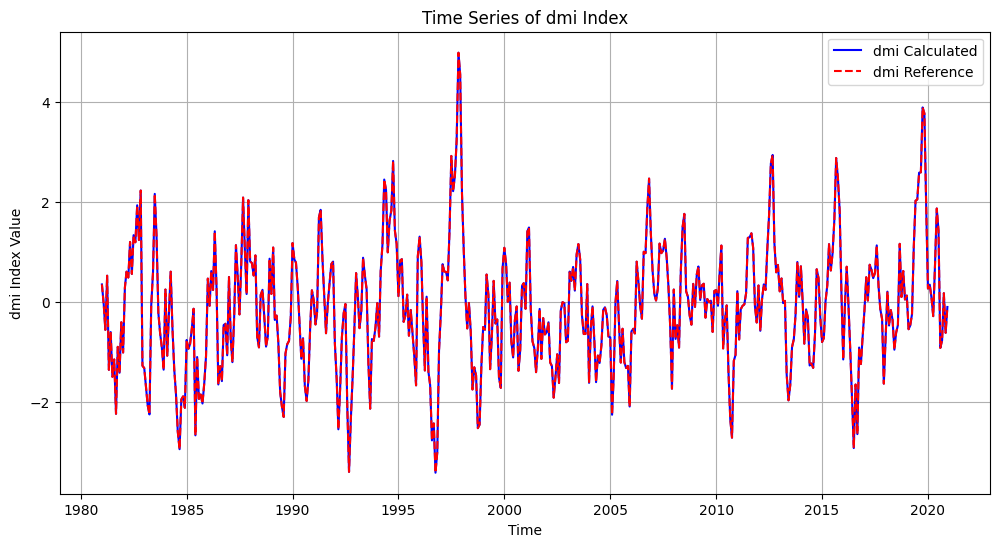

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 1.9419364929199219
Reference value: 1.9418332171625


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.2652451992034912
Reference value: 0.265314241227996


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.3432576656341553
Reference value: 0.343302725351841


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.08859562873840332
Reference value: 0.0886621333093891


Validating index: dmi_diff1


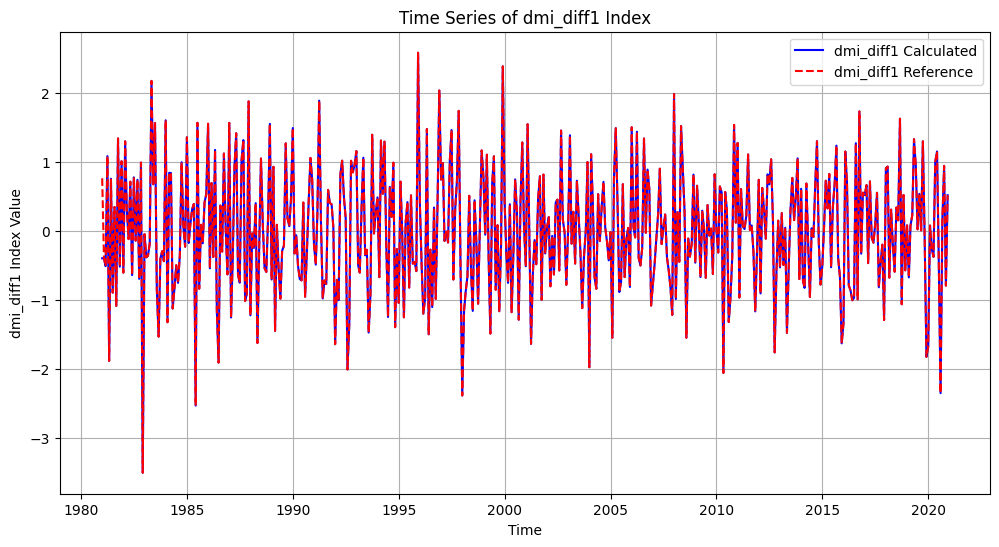

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.8267383575439453
Reference value: -1.82678177870107


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -1.6766912937164307
Reference value: -1.6765189759345


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.07801246643066406
Reference value: 0.0779884841238445


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.25466203689575195
Reference value: -0.254640592042452


Validating index: n3


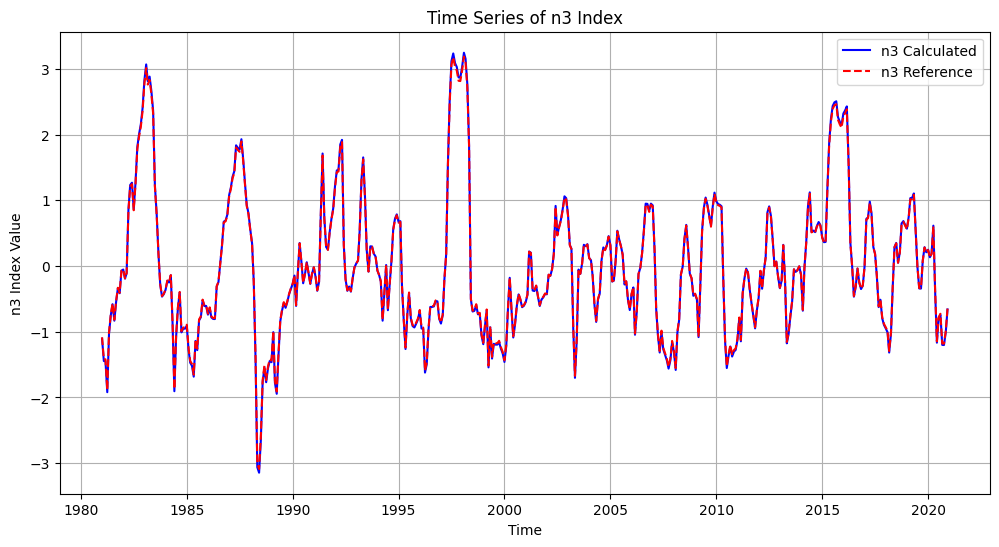

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.20983758568763733
Reference value: 0.206019603912169


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.2482137680053711
Reference value: 0.243756788163554


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.13393370807170868
Reference value: 0.13158023441094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.18719516694545746
Reference value: 0.183879605622572


Validating index: n34


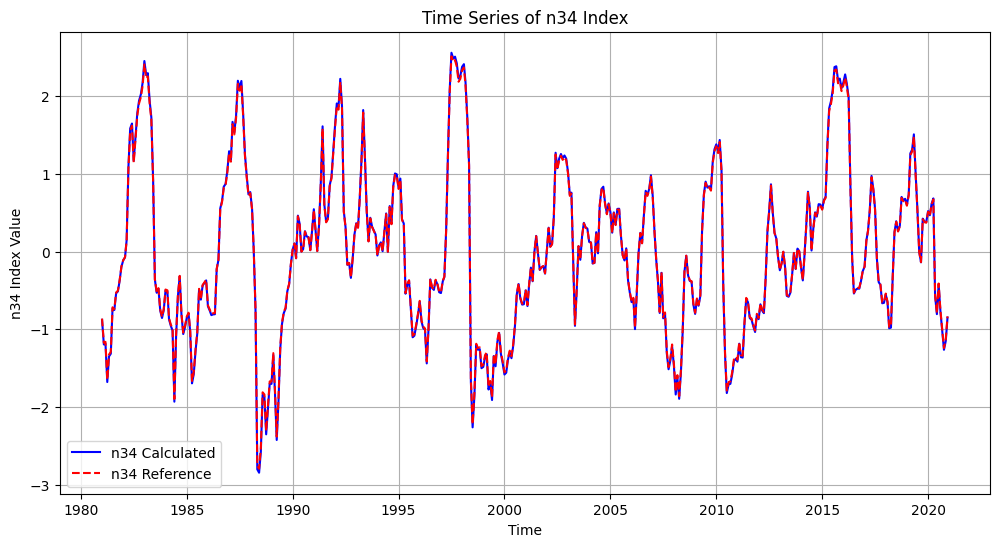

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.37987130880355835
Reference value: 0.372994201030477


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.522404134273529
Reference value: 0.513009703875565


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.4692562520503998
Reference value: 0.460850765524855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.6152685284614563
Reference value: 0.604228159008709


Validating index: n34_diff1


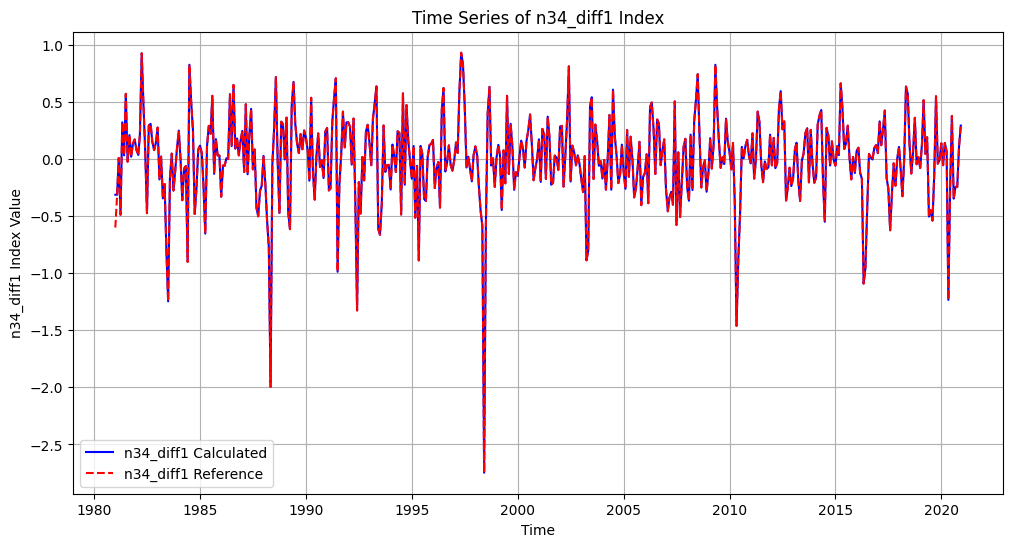

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -0.005655646324157715
Reference value: -0.0056419748808896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.1399645209312439
Reference value: 0.140015502845088


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -0.05219024419784546
Reference value: -0.0521589383507099


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.1433812379837036
Reference value: 0.143377393483854


Validating index: n4


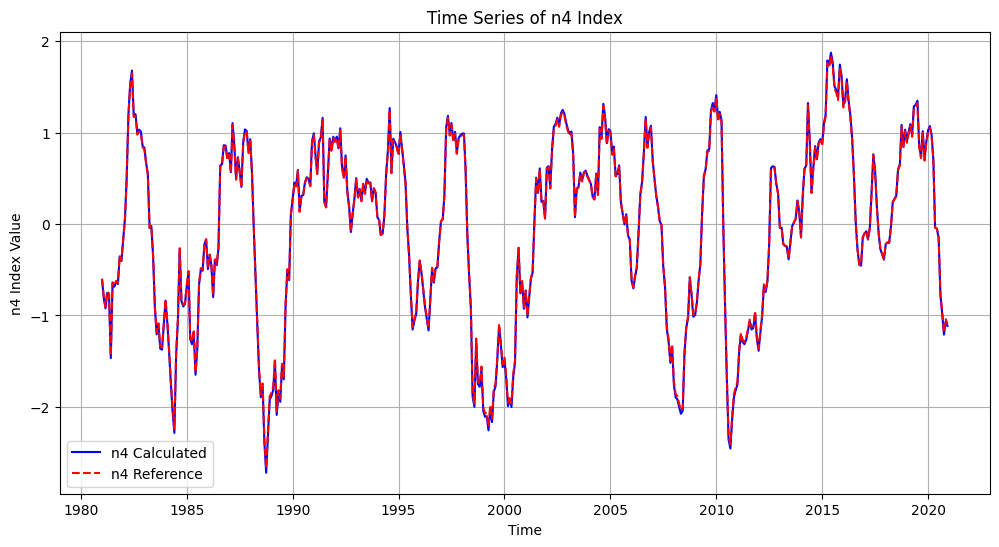

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.8953214883804321
Reference value: 0.879144916265894


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 1.024899959564209
Reference value: 1.00643704571476


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 1.0707846879959106
Reference value: 1.05155372046276


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.9801605939865112
Reference value: 0.96257094914962


Validating index: sji200


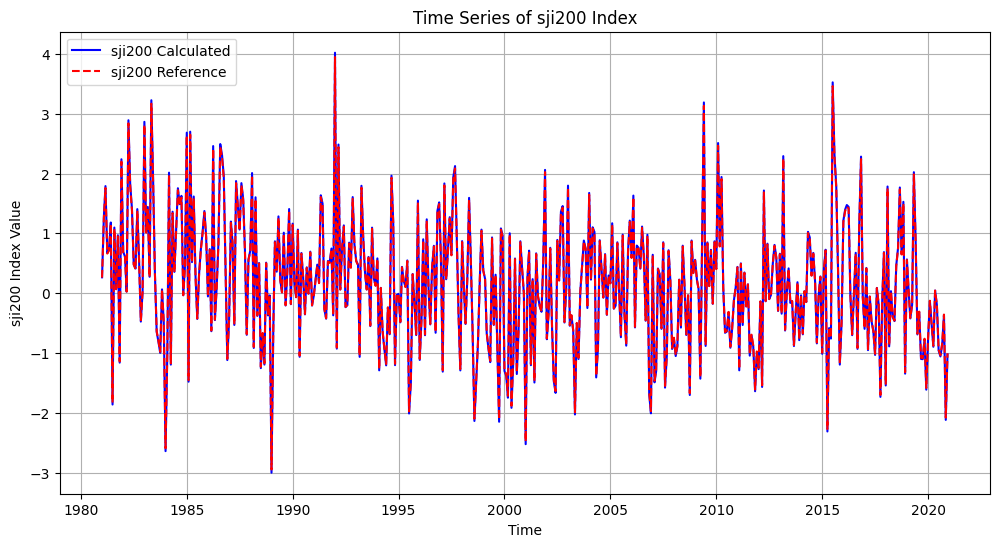

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.6115000247955322
Reference value: -1.58246167948365


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -0.7603710889816284
Reference value: -0.746669580627106


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -0.12836050987243652
Reference value: -0.126047556243128


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.5111793875694275
Reference value: -0.501968169565544


Validating index: sji850


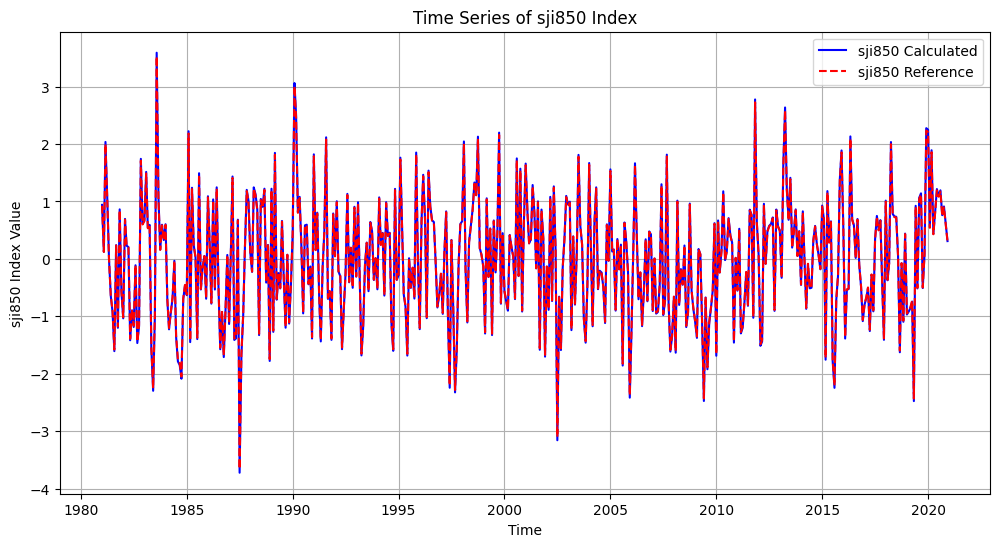

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 2.2761528491973877
Reference value: 2.23513716972386


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 2.2494091987609863
Reference value: 2.20887629889085


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.5522845387458801
Reference value: 0.542333684632671


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.8918044567108154
Reference value: 1.85771575568932


Validating index: ueq200


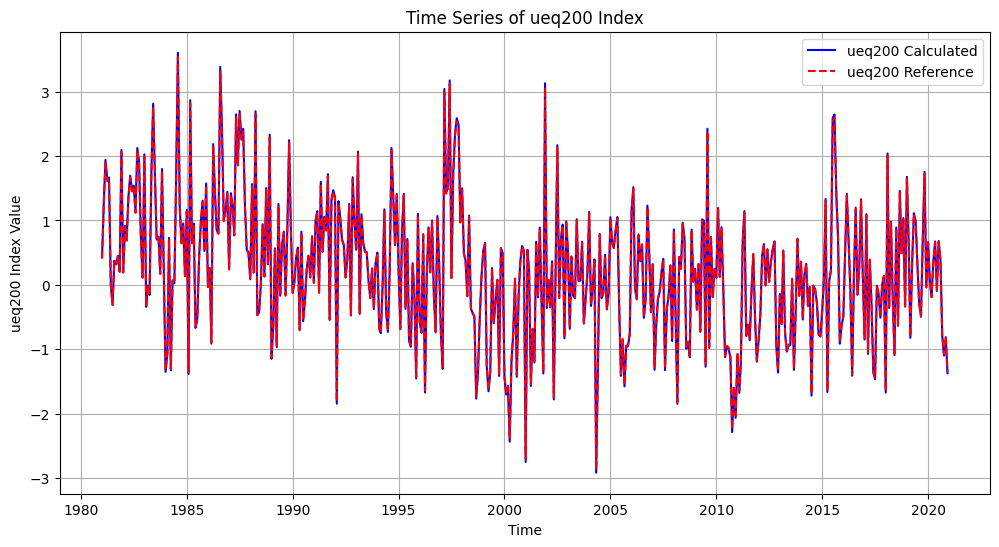

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -0.03881261497735977
Reference value: -0.0381129128773105


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.6620338559150696
Reference value: 0.65010424548631


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.05884569510817528
Reference value: 0.0577853047959282


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.19194722175598145
Reference value: -0.188488269519044


Validating index: ueq850


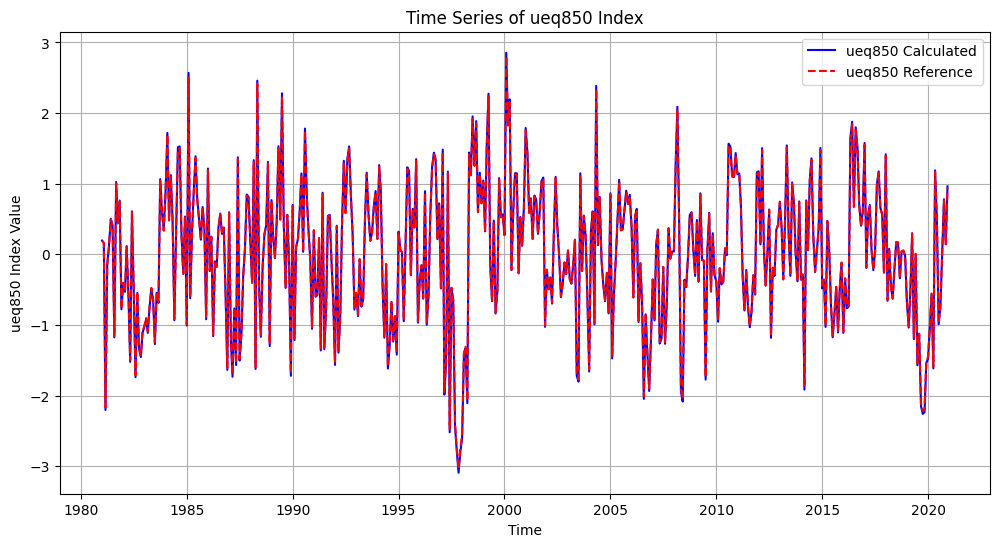

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.5403413772583008
Reference value: -1.51258507670805


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -1.473352313041687
Reference value: -1.44680336146896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -1.0252622365951538
Reference value: -1.0067874838614


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.5642094612121582
Reference value: -0.554042589497677


Validating index: wnp


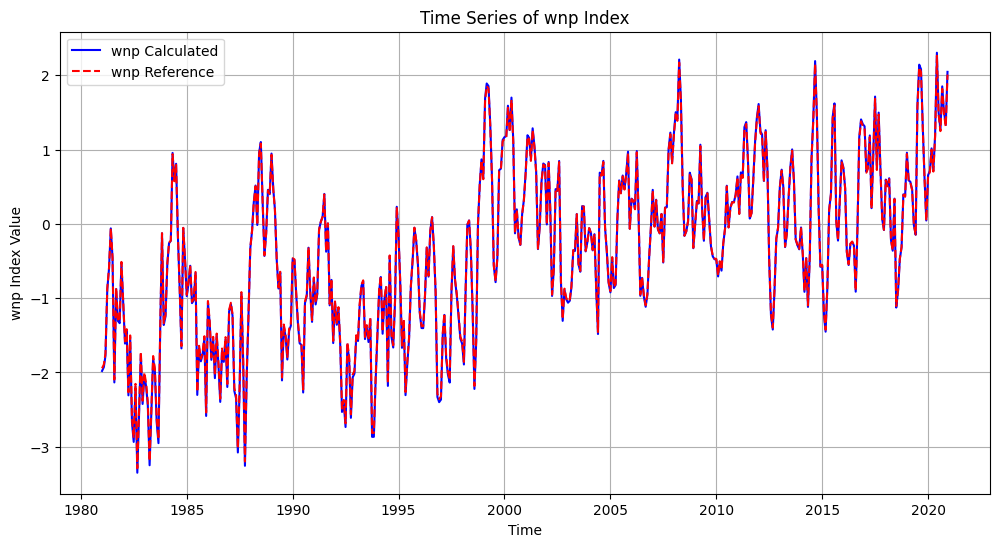

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.044872310012578964
Reference value: 0.0439991073142581


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.653798520565033
Reference value: 0.642058242147582


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.7116570472717285
Reference value: 0.698954206422623


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.0151039361953735
Reference value: 0.99688132465


Validating index: wp


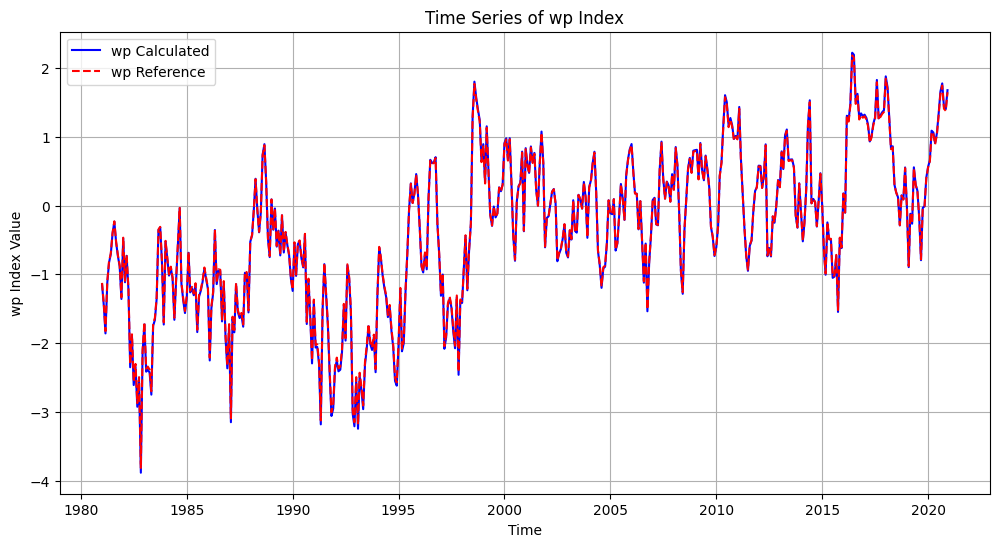

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.4036230146884918
Reference value: 0.3965014406094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.5627392530441284
Reference value: 0.552468608350522


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.6579357385635376
Reference value: 0.645874754009963


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.0894144773483276
Reference value: 1.06964466368143


Validating index: wpg


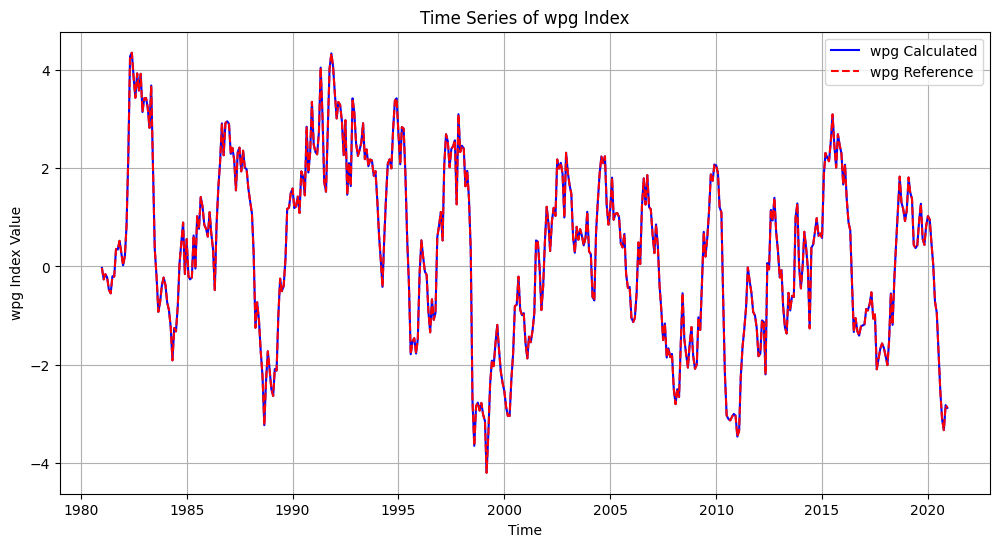

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.8253048062324524
Reference value: 0.8253758807116


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 1.0249437093734741
Reference value: 1.02486499573251


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.952954888343811
Reference value: 0.952911481535054


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.48157668113708496
Reference value: 0.481602647259719


Validating index: wsp


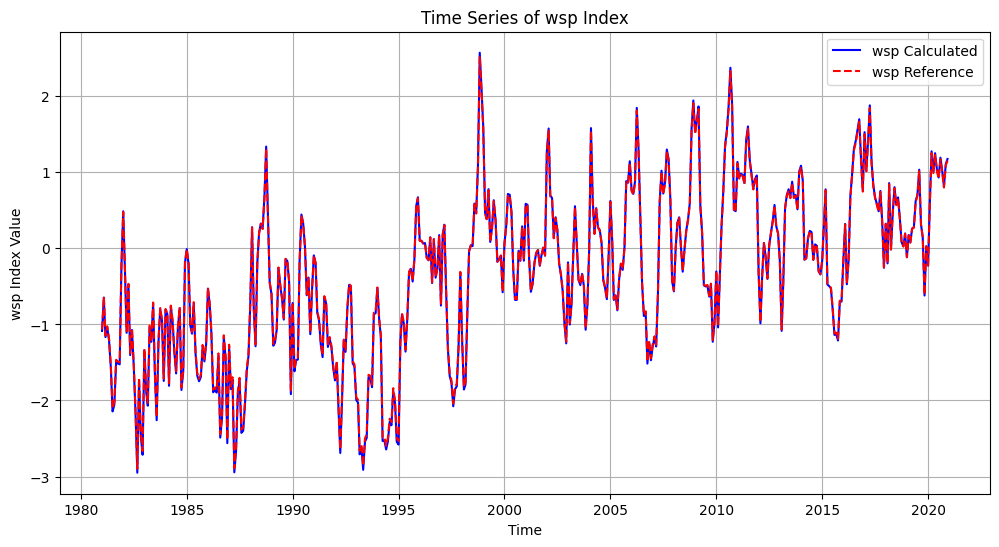

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.026800455525517464
Reference value: 0.0263166023317855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -0.2280745953321457
Reference value: -0.223977062664927


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.6117443442344666
Reference value: 0.600790106588463


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.2746162414550781
Reference value: 1.25162967063952


Validating index: wvg


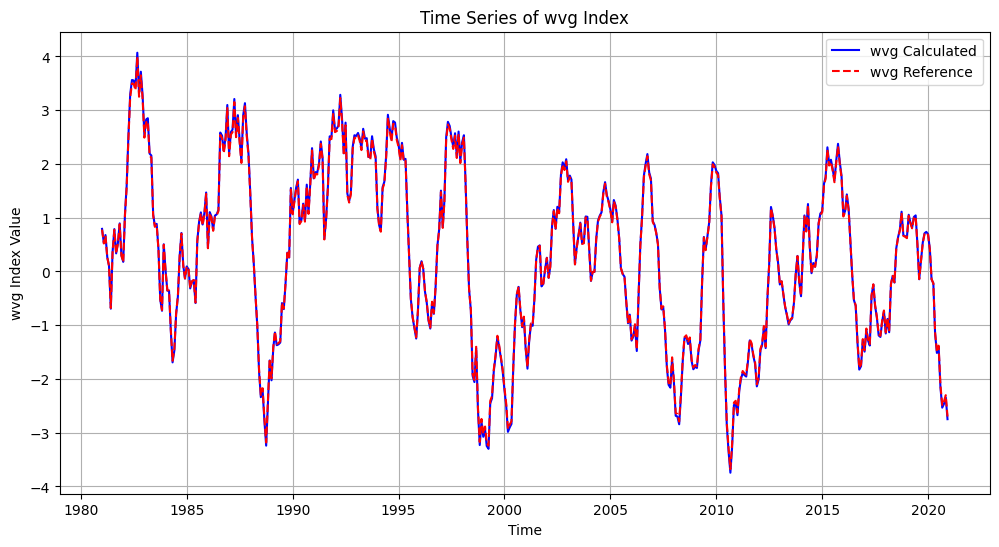

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.7368895610173544
Reference value: 0.72353919951408


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.6954122583071392
Reference value: 0.682920449770368


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.41033899784088135
Reference value: 0.403014031455744


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.14621762434641528
Reference value: -0.14348093717403




In [19]:
# Plot time series of each index comparing with reference, and print some numbers for verification
filepath_indices = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/refper_1993-2020/indices/'
validate_indices(era5_indices, filepath_indices, period_train, year_fcst)

### ML model

Precip data:  
eofs_norm_anomalies_reshaped, numpy array of shape (eof = n_eofs, lat = 67, lon = 59)  
pcs_ano_normal, numpy array of shape (year = train_end - train_start, n_eofs)  
var_frac_ano_normal, numpy array of shape (n_eofs, )  
Features/predictors: (dataframe with shape (year, month, standardized_anomaly))  
time_series_{feature}_df for feature in ['n34','dmi','wvg','wsp','wpg','wp','wnp','n34_diff1','dmi_diff1','ueq850','ueq200','sji850','sji200']

##### Get/calculate ML model

In [20]:
feature_names = ['n34','dmi','wvg','wsp','wpg','wp','wnp','n34_diff1','dmi_diff1','ueq850','ueq200','sji850','sji200']

# Get model coefficients and covariances, or train model
if not path.exists(f'{val_dir}model_coefficients.nc'):
    df_coefficients, df_fl_pred_cov = get_ml_results(era5_indices, feature_names, pcs, var_fracs, n_eofs, period_train, period_clm, month_init)
    save_model_results(df_coefficients, df_fl_pred_cov, val_dir)
else:
    df_coefficients = xr.load_dataset(f'{val_dir}model_coefficients.nc').to_dataframe()
    
    cov_ds = xr.load_dataset(f'{val_dir}prediction_covariances.nc')
    cov_array = cov_ds.covariance.values
    years = cov_ds.year.values
    n_eofs = cov_array.shape[1]
    
    # Reconstruct df_fl_pred_cov
    df_fl_pred_cov = pd.DataFrame(
        index=years,
        columns=[f'cov-{i}{j}' for i in range(1, n_eofs + 1) for j in range(1, n_eofs + 1)],
        data=cov_array.reshape(len(years), -1)
    )
print(df_coefficients)
print(df_fl_pred_cov)  


             year  n34         dmi  wvg  wsp         wpg   wp  dmi_diff1  \
index                                                                      
eof1   265.377482  0.0  385.009397  0.0  0.0  360.428245  0.0        0.0   
eof2   158.088765  0.0   32.879245  0.0  0.0   29.938116  0.0        0.0   
eof3    62.903579  0.0   57.862864  0.0  0.0  -26.507569  0.0        0.0   
eof4    36.080649  0.0   32.794292  0.0  0.0  -31.635423  0.0        0.0   
eof5   -60.761696  0.0  -25.966690  0.0  0.0    9.664622  0.0        0.0   
eof6    89.830622  0.0    4.851010  0.0  0.0  -29.805405  0.0        0.0   
eof7    51.108384  0.0   30.528021  0.0  0.0  -21.828449  0.0        0.0   

       sji850      sji200  
index                      
eof1      0.0  125.335866  
eof2      0.0  -26.709718  
eof3      0.0   13.137259  
eof4      0.0   -2.051493  
eof5      0.0   -7.717420  
eof6      0.0   13.480870  
eof7      0.0  -31.782856  
            cov-11         cov-12         cov-13        cov-14 

##### Plots to ensure calculating ML model went well

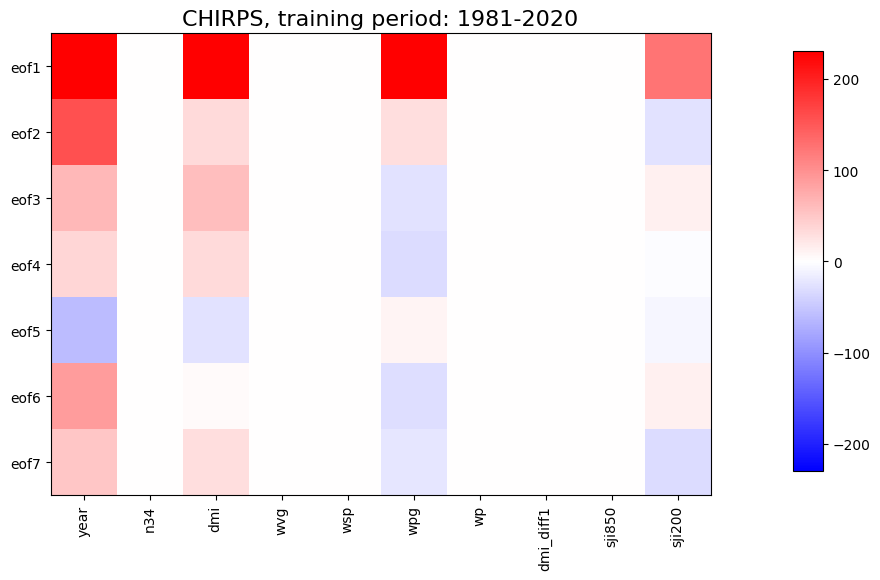

In [21]:
validate_ml_coefficients(df_coefficients, period_train, season, month_init)

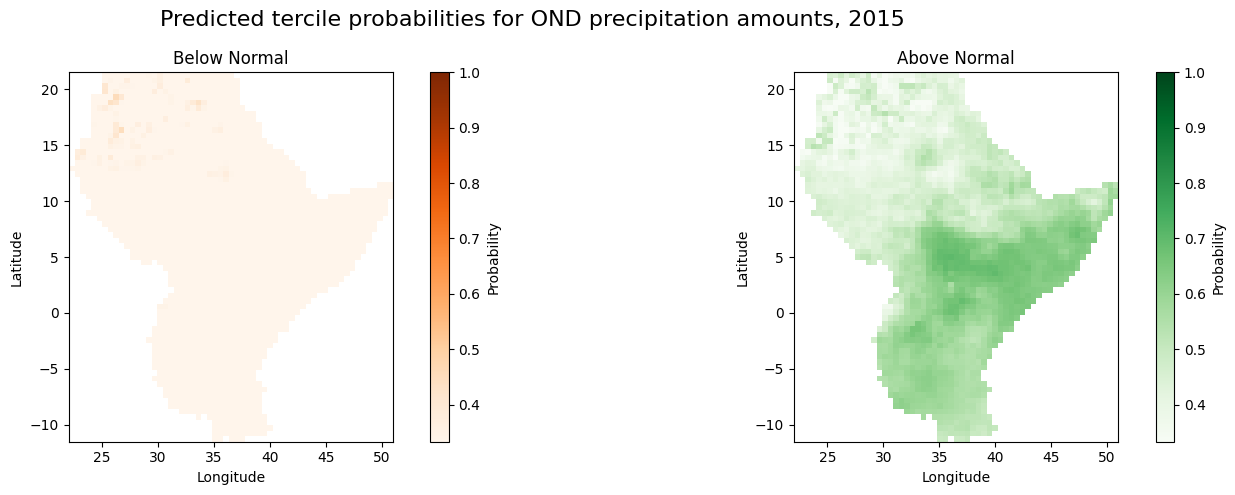

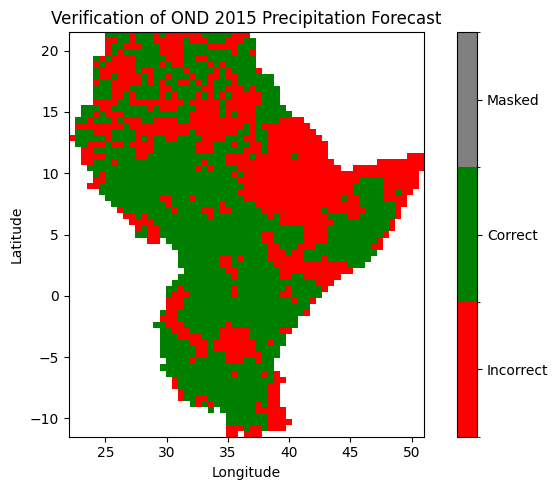

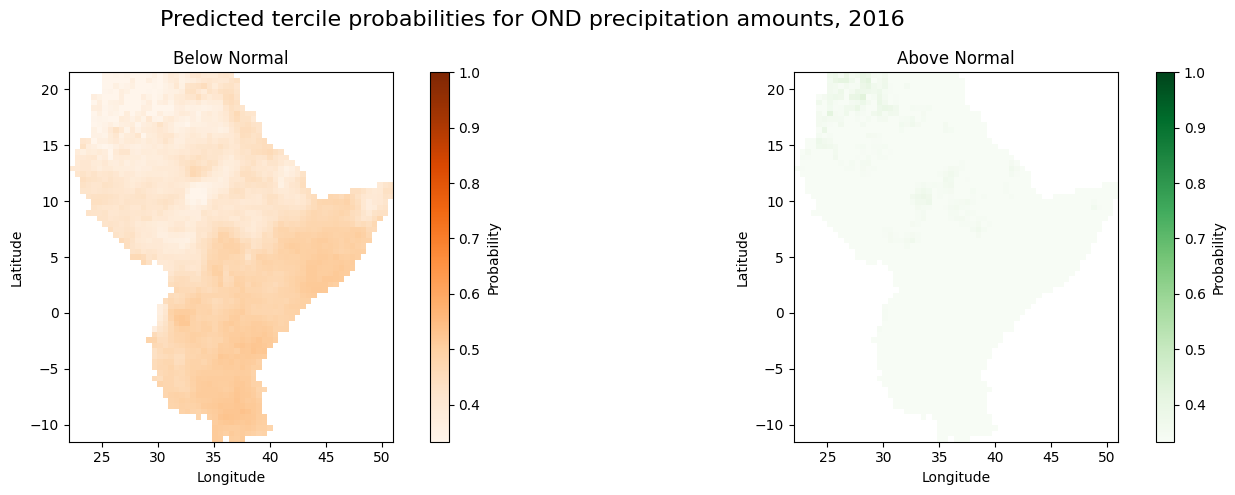

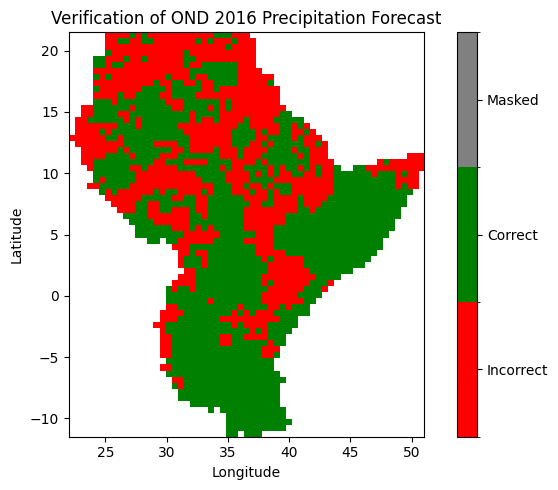

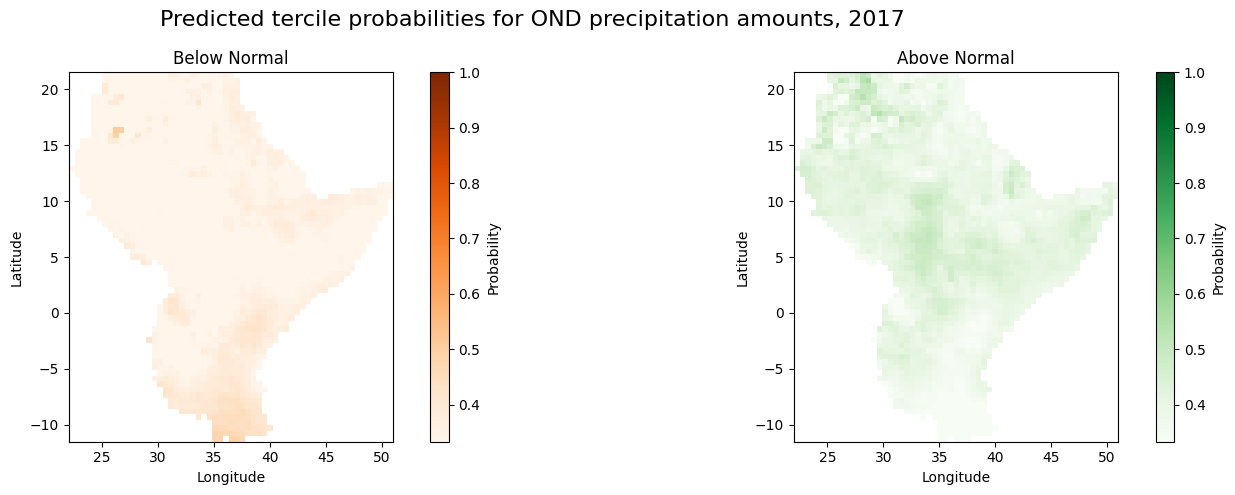

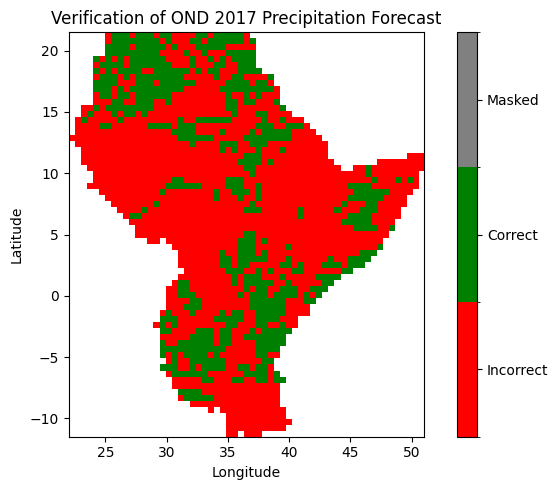

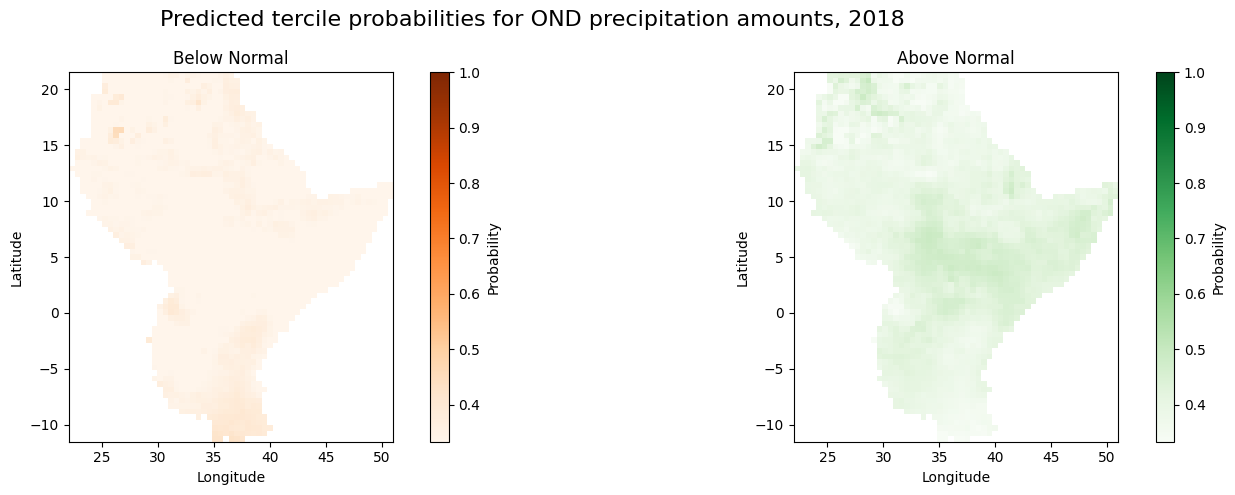

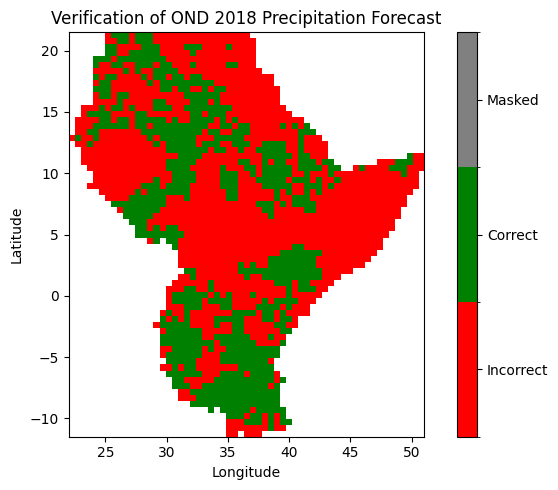

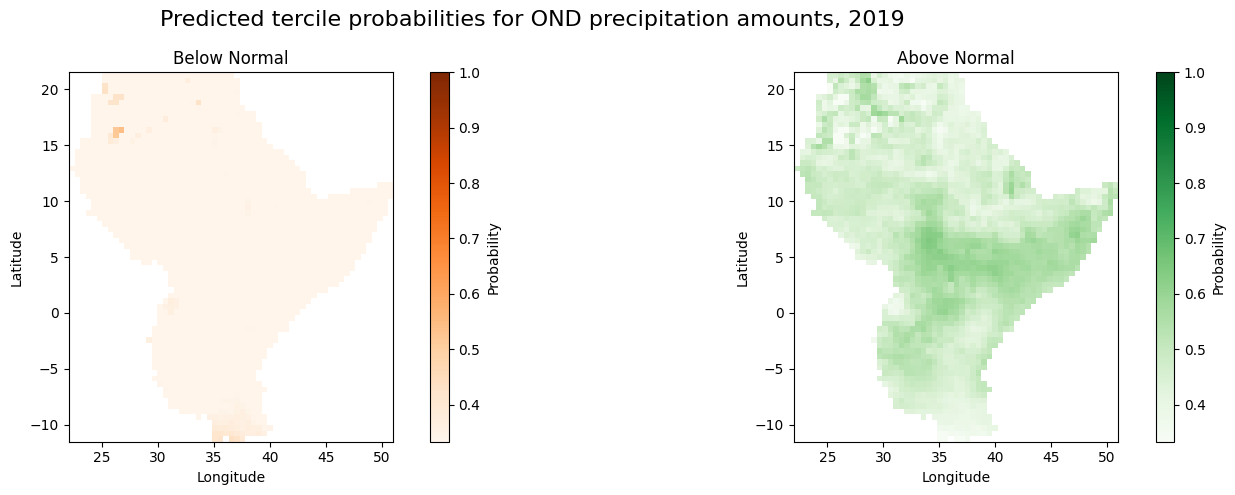

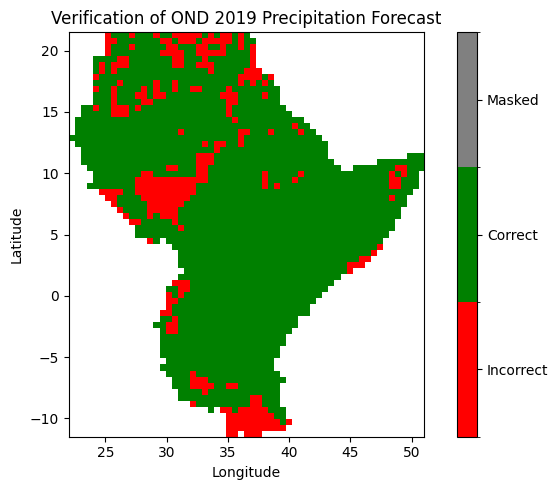

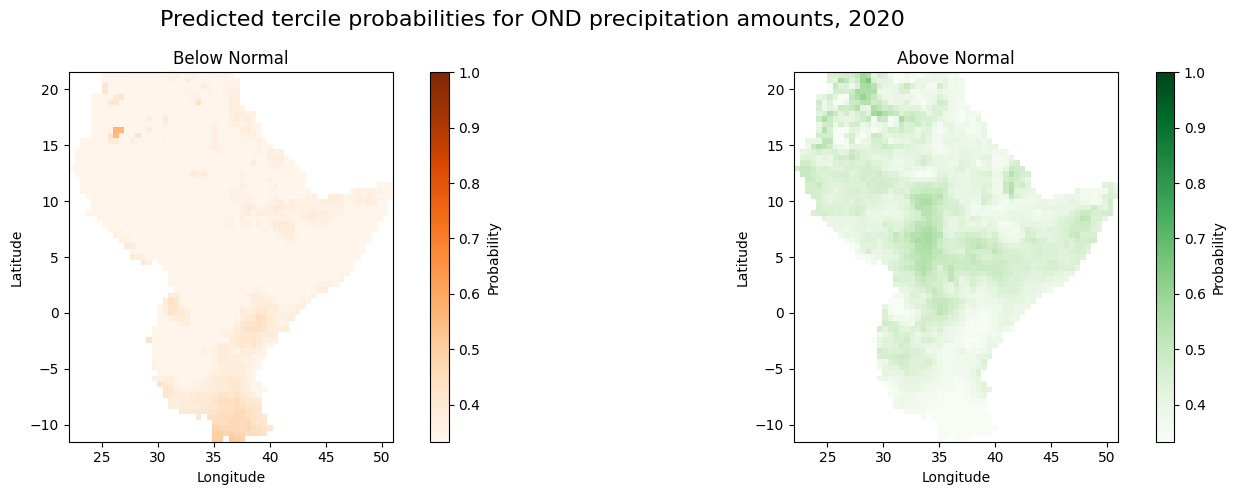

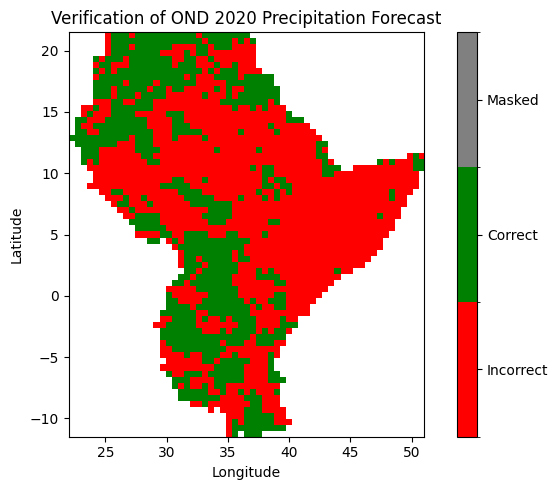

In [22]:
# Verifying tercile forecast predictions for some recent years
for year_fcst in range(2015, 2021):
    # Get tercile probability forecasts
    prob_bn, prob_an = calculate_tercile_probability_forecasts(era5_indices, anomalies_normal, eofs_reshaped, df_coefficients, df_fl_pred_cov, var_fracs, feature_names, year, period_clm, n_eofs, year_fcst, month_init)

    # Plot the probabilities
    plot_fields_simple(fields=[prob_bn, prob_an],
                titles=['Below Normal', 'Above Normal'],
                cmap=['Oranges', 'Greens'],
                unit='Probability',
                lat = lat,
                lon = lon,
                season=season,
                year=year_fcst)
    
    # Plot the verification
    validate_forecast(prob_bn, prob_an, prec_data, period_clm, period_train, year, lat, lon, season, year_fcst)
